In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import json
from ctypes import *
import time
%matplotlib inline

In [2]:
board_size = 30
device = torch.device('cuda')
batch_size = 32
# ctypes init
bfs = CDLL("./bfs.so")
a = c_int * (900 * 450 * 2)

In [3]:
class blockington(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        stride = 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [4]:
class resnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            blockington(1, 256, 1),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            nn.MaxPool2d(3, stride=2),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            nn.MaxPool2d(3, stride=2),
            blockington(256, 256, 1),
            blockington(256, 256, 1),
            nn.MaxPool2d(3, stride=2),
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    def forward(self, x):
        return self.layers(x)

In [5]:
# resnetington = resnet()
resnetington = torch.load("model")
losses = []
train = []
resnetington.to(device)
running_loss = 0.1

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(resnetington.parameters(), lr=1e-4) # reiniting adam is pretty bad (avoid)

In [7]:
for epoch in range(100):
    dataset = []
    raw_dataset = a()
    length = bfs.gameSim(raw_dataset)
    for row_index in range(length):
        temp = []
        for col_index in range(row_index):
            t = (raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2], raw_dataset[int(row_index * (row_index + 1) / 2 + col_index) * 2 + 1])
            temp.append(t)
        dataset.append(temp)
    
    for sample in dataset:
        rand = int(np.random.rand() * len(train))
        sample.append(length/900)
        train.append(sample)
        if len(train) > 10000:
            train.remove(train[rand])
    
    batch = torch.zeros(1, 1, 30, 30, device=device)
    labels = torch.zeros(batch_size, 1, device=device)
    
    for i in range(batch_size):
        rand = int(np.random.rand() * len(train))
        sample = train[rand][:len(train[rand]) - 1]
        labels[i] = train[rand][len(train[rand]) - 1:][0]
        board = torch.zeros(board_size, board_size, device=device)
        for number, tupl in enumerate(sample):
            board[tupl] = ((number + 1)/len(sample))
        batch = torch.cat([batch, board.view(1, 1, 30, 30)], dim=0)
        
    batch = torch.cat((batch[:0], batch[0+1:])) # remove first row
    optimizer.zero_grad()
    outputs = resnetington(batch) #(length, moves)
    loss = loss_function(outputs, labels)
    running_loss = (running_loss * 0.9) + (loss.item() * 0.1)
    print(running_loss)
    losses.append(running_loss)
    loss.backward()
    optimizer.step()

0.09092259496450425
0.08339011675119401
0.07547004689238966
0.06854076471816749
0.06235930924690888
0.05660448363864832
0.05125999148736369
0.04675947831205998
0.04253597886196501
0.03862081787174994
0.03530839512440014
0.03196968642300694
0.02903164401305165
0.026523725135869793
0.02423987952619524
0.022181855710593442
0.020274430922565683
0.01854907273819848
0.016858193651661017
0.015399545771807199
0.01415208264180699
0.01308459518597584
0.01203001448061521
0.011065835712520377
0.01043897062525281
0.00966087437594052
0.009096117305077157
0.008483861622237004
0.007936605948528203
0.0073279412326288694
0.006930817977300805
0.006446609644296636
0.006231742965313377
0.005952788146629258
0.005604500386121264
0.005332419202180855
0.005002960929120022
0.004676893927707021
0.004417131147283684
0.004210587739421461
0.004022747132456482
0.003852200027690393
0.0037469184312323295
0.003587738683128318
0.003517217766392792
0.0033473484571116255
0.0032589938809278983
0.0031923783763322276
0.00319

KeyboardInterrupt: 

In [34]:
y = np.zeros(900)

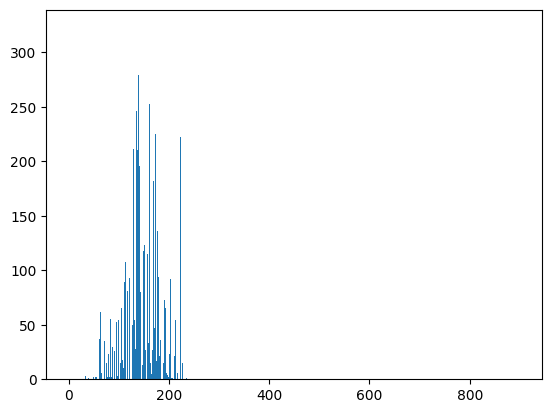

In [35]:
for i in train:
    y[int(i[len(i)-1]*900)] += 1
#     raw_dataset = a()
#     length = bfs.gameSim(raw_dataset)
#     y[length] += 1
# print(np.argmax(y))
x = np.arange(900)
plt.bar(x, y, width=1)
plt.show()

In [8]:
len(train)

1000

In [53]:
torch.save(resnetington, "model")

In [8]:
xs = []
ys = []

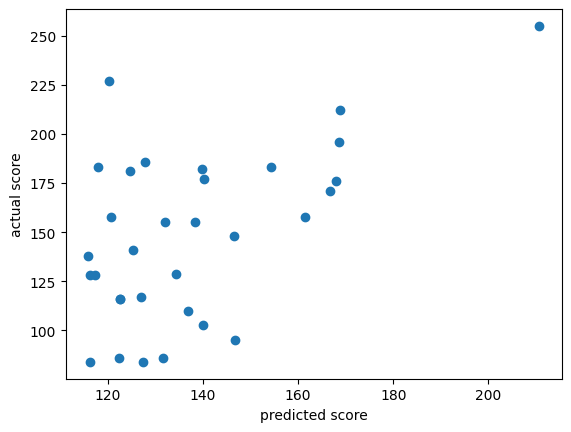

In [9]:
for epoch in range(10):
    resnetington.eval()
    
    batch = torch.zeros(1, 1, 30, 30, device=device)
    labels = torch.zeros(batch_size, 1, device=device)
    
    for i in range(batch_size):
        rand = int(np.random.rand() * len(train))
        sample = train[rand][:len(train[rand]) - 1]
        labels[i] = train[rand][len(train[rand]) - 1:][0]
        board = torch.zeros(board_size, board_size, device=device)
        for number, tupl in enumerate(sample):
            board[tupl] = ((number + 1)/len(sample))
        batch = torch.cat([batch, board.view(1, 1, 30, 30)], dim=0)
        
    batch = torch.cat((batch[:0], batch[0+1:])) # remove first row
    outputs = resnetington(batch) 
    
    outputs = torch.Tensor.cpu(outputs)
    labels = torch.Tensor.cpu(labels)
    
    outputs = outputs.detach()

plt.xlabel("predicted score")
plt.ylabel("actual score")
plt.scatter(outputs*900, labels*900)

In [52]:
board = torch.zeros(board_size, board_size, device=device)
board[(14, 12)] = 1
innington = board.view(1, 1, 30, 30)
mlp.eval()
logits = mlp(innington)
length = logits[0][0].item() * 900
print(length)
mlp.train()

110.0611075758934


MLP(
  (layers): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (16): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

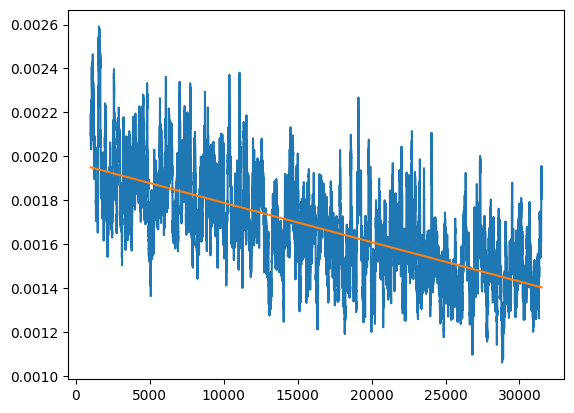

In [44]:
smooth = 1
start = 1000
x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
c, b = np.polyfit(x[start:], y[start:], 1)
plt.plot(x[start:], y[start:])
plt.plot(x[start:], c*x[start:]+b)